In [14]:
import ADerrors as AD
import HDF5
import Plots
import StatsPlots
import Statistics as Stats
import CorrelatorAnalysis as CA
using LaTeXStrings

Read the correlator matrix from the HDF5 file

In [15]:
file_path = "../test/data/correlator_matrix.hdf5"
file = HDF5.h5open(file_path)
corr_matrix = read(file["Correlator Matrix"])
close(file)
Nₜ, N_op, _, N_cnfg = size(corr_matrix)

(33, 3, 3, 1612)

Construct the `uwreal` correlator matrix

In [16]:
mcid = "B450r000"
Cₜ = CA.uwreal_array(corr_matrix, mcid, :auto);

Compute the effective energies of the lowest few states (three in this case) and perform plateau fits to them

In [17]:
aE_eff = CA.GEVP(Cₜ, :ceil_t_half)
CA.err!.(aE_eff)

plateau_range = [15, 24]

# Ground state energy
fit_result = CA.fit_plateau(aE_eff[1], plateau_range, fit_type=:correlated_posdef)
aE0 = CA.err!(fit_result.param[1])

# Energy of first excited state
fit_result = CA.fit_plateau(aE_eff[2], plateau_range, fit_type=:correlated_posdef)
aE1 = CA.err!(fit_result.param[1])

# Energy of second excited state
fit_result = CA.fit_plateau(aE_eff[3], plateau_range, fit_type=:correlated_posdef)
aE2 = CA.err!(fit_result.param[1]);

Plot the result

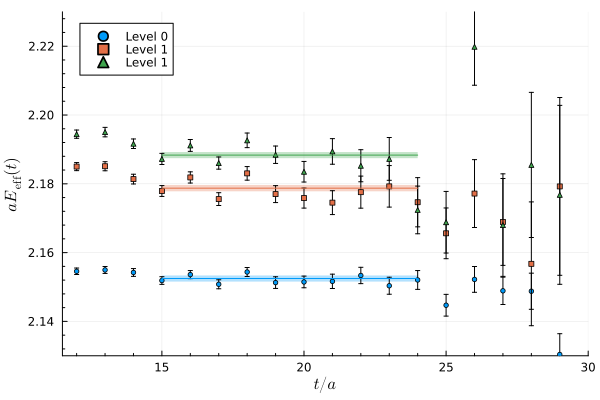

aE0 = 2.1524622389214803 +/- 0.0008896215919601967
aE1 = 2.17874053787349 +/- 0.0009186633907838645
aE2 = 2.1883420746340887 +/- 0.0008906508771061862


In [18]:
plt = Plots.plot(xlim=[11.5, 30], ylim=[2.13, 2.23])

CA.plot_effective_energy!(aE_eff[1], label="Level 0", color=1, marker=:circle)
CA.plot_effective_energy!(aE_eff[2], label="Level 1", color=2, marker=:square)
CA.plot_effective_energy!(aE_eff[3], label="Level 1", color=3, marker=:utriangle)
CA.plot_error_rectangle!(aE0, plateau_range, color=1, label=nothing)
CA.plot_error_rectangle!(aE1, plateau_range, color=2, label=nothing)
CA.plot_error_rectangle!(aE2, plateau_range, color=3, label=nothing)
display(plt)

@show aE0
@show aE1
@show aE2;

Analysis of the overlap

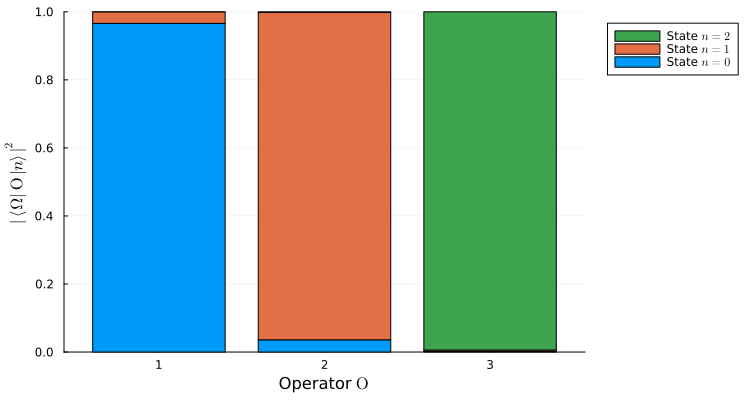

In [ ]:
# Specify the time range over which the overlaps are averaged
time_range = [15, 24]

# Compute overlaps
aE_arr = [aE0, aE1, aE2]
Z_in = Stats.mean(CA.overlaps_Z.([Cₜ], [aE_arr], time_range))

# Compute overlap of operators with eigenstates of the Hamiltonian
Z_in = CA.overlaps_Z(Cₜ, [aE0, aE1, aE2], 20)

# Specify operator range for plot
i_n_range = 1:3

# Plot overlaps
labels = [L"State $n=%$(i_n-1)$" for i_n in i_n_range]
plt = Plots.plot(xlabel=L"Operator $\mathrm{O}$",
                 ylabel=L"|\langle \Omega|\mathrm{O} \;|n \rangle\;|^2",
                 ylim=[0, 1], xticks=1:3, legend=:outertopright,
                 bottom_margin=3Plots.mm, left_margin=3Plots.mm, size=[600+150, 400])
# Reverse plotting order such that the ground state is plotted first
StatsPlots.groupedbar!(Z_in[:, reverse(i_n_range)], bar_position=:stack,
                       label=permutedims(reverse(labels)),
                       color=permutedims(reverse(i_n_range)))